## Imports

In [2]:
%load_ext autoreload
%autoreload 2

from mxnet import gluon, init, nd, autograd
from mxnet.gluon import data as gdata, loss as gloss, model_zoo
from mxnet.gluon import utils as gutils
import subprocess
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np
from skimage import io

import mxnet as mx
from mxnet import lr_scheduler
import pandas as pd
import os
import cv2

#FOLDER = '/Users/francesco/Notebooks/personal/data/movies'
FOLDER = '/tmp/data'

ModuleNotFoundError: No module named 'skimage'

## Data Preprocessing

In [3]:
df = pd.read_csv(os.path.join(FOLDER, 'MovieGenre.csv'), encoding='latin1')
df = df.drop_duplicates()
df = df.loc[~pd.isnull(df.Genre)]
df.shape

NameError: name 'pd' is not defined

In [3]:
df['split_genres'] = df.Genre.str.split('|')
df['abs_path'] = df.imdbId.apply(lambda x: os.path.join(FOLDER, 'posters', str(x) + '.jpg'))
df['check'] = df.abs_path.apply(lambda x: 0 if cv2.imread(x) is None else 1)
df['path'] = df.imdbId.astype(str) + '.jpg'

df = df.loc[df.check == 1]

In [4]:
df['thriller'] = df.Genre.apply(lambda x: 1 if 'Thriller' in x else 0)
df['crime'] = df.Genre.apply(lambda x: 1 if 'Crime' in x else 0)
df['romance'] = df.Genre.apply(lambda x: 1 if 'Romance' in x else 0)
df['comedy'] = df.Genre.apply(lambda x: 1 if 'Comedy' in x else 0)

In [5]:
yes = df.loc[(df.thriller==1) & (df.crime==1) & (df.comedy==0) & (df.romance==0)]
no = df.loc[~df.index.isin(yes.index)].sample(len(yes), random_state=42)

yes['thriller_crime'] = 1
no['thriller_crime'] = 0

yes.shape, no.shape

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


((1099, 15), (1099, 15))

In [6]:
total = yes.append(no)
total = total.sample(frac=1)
total = total[['abs_path', 'thriller_crime']]
total.columns = ['name', 'label']

In [7]:
total.name = total.name.apply(lambda x: x.replace('/tmp/data/', ''))

In [8]:
total.head()

,name,label
23042,posters/2095568.jpg,1
12558,posters/817538.jpg,0
16829,posters/926084.jpg,0
9894,posters/399901.jpg,0
20971,posters/1867093.jpg,1


In [9]:
total.to_csv(os.path.join(FOLDER, 'labels.csv'), index=False)

In [8]:
total = yes.append(no)
total['path'] = total.imdbId.astype(str) + '.jpg'
total = total[['imdbId', 'thriller_crime', 'path']]

raw_train = total.sample(int(len(total)*.8), random_state=42).sample(frac=1)
raw_valid = total.loc[~total.index.isin(raw_train.index)].sample(frac=1)

raw_train.shape, raw_valid.shape

In [17]:
def save_lst(x, name):
    x.to_csv(os.path.join(FOLDER, 'temp.lst'), index=False, header=None, sep='\t')
    
    with open(os.path.join(FOLDER, 'temp.lst'), "rt") as fin:
        with open(os.path.join(FOLDER, name), "wt") as fout:
            for line in fin:
                fout.write(line.replace('"', ''))

In [19]:
save_lst(raw_train, 'train_bi.lst')
save_lst(raw_valid, 'valid_bi.lst')

In [22]:
! head /tmp/data/train_bi.lst

1474276	0	1474276.jpg
438427	0	438427.jpg
357668	0	357668.jpg
79839	0	79839.jpg
380485	0	380485.jpg
118688	0	118688.jpg
52844	0	52844.jpg
2072933	1	2072933.jpg
1092006	0	1092006.jpg
351795	0	351795.jpg


In [9]:
## RUN FROM TERMINAL

# python /Users/francesco/anaconda3/envs/fraenv37/lib/python3.6/site-packages/mxnet/tools/im2rec.py train.lst posters/ --pack-label
# python /Users/francesco/anaconda3/envs/fraenv37/lib/python3.6/site-packages/mxnet/tools/im2rec.py valid.lst posters/ --pack-label
# python /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/tools/im2rec.py train.lst posters/

## Testing on single image

In [43]:
def read_image(filename):
    data = mx.nd.array(io.imread(filename))
    data = data.astype('float32')/255
    augs = mx.image.CreateAugmenter(data_shape=(3,64,64),
                                    mean=mx.nd.array([0.485, 0.456, 0.406]), 
                                    std=mx.nd.array([0.229, 0.224, 0.225]))
    for aug in augs:
        data = aug(data)
    data = nd.transpose(data, (2,0,1))
    data = nd.expand_dims(data, axis=0)

    return data

In [56]:
img = read_image(os.path.join(FOLDER, '1563719.jpg'))
img = img.copyto(mx.gpu(0))

In [57]:
preds = model(img)
preds.argmax(axis=1)


[ 1.]
<NDArray 1 @gpu(0)>

## Deep Learning

In [36]:
def train_aug_transform(data, label):
    data = data.astype('float32')/255
    augs = mx.image.CreateAugmenter(data_shape=(3,182,182),
                                    rand_crop=0.5, rand_mirror=True, inter_method=10,
                                    brightness=0.125, contrast=0.125, saturation=0.125,
                                    pca_noise=0.02, mean=mx.nd.array([0.485, 0.456, 0.406]), 
                                    std=mx.nd.array([0.229, 0.224, 0.225]))
    for aug in augs:
        data = aug(data)
    data = nd.transpose(data, (2,0,1))
    return data, label

def valid_aug_transform(data, label):
    data = data.astype('float32')/255
    augs = mx.image.CreateAugmenter(data_shape=(3,182,182),
                                    mean=mx.nd.array([0.485, 0.456, 0.406]), 
                                    std=mx.nd.array([0.229, 0.224, 0.225]))
    for aug in augs:
        data = aug(data)
    data = nd.transpose(data, (2,0,1))
    return data, label

def standard_transform(data, label):
    data = data.astype('float32')
    augs = mx.image.CreateAugmenter(data_shape=(3, 224, 224))
    for aug in augs:
        data = aug(data)
    return data, label

def plot_mx_array(array):
    """
    Array expected to be height x width x 3 (channels), and values are floats between 0 and 255.
    """
    assert array.shape[2] == 3, "RGB Channel should be last"
    imshow((array.clip(0, 255)/255).asnumpy())
    
def show_batch(rec_file):
    dataset = mx.gluon.data.vision.ImageRecordDataset(os.path.join(FOLDER, rec_file),
                                                     transform=standard_transform)
    loader = mx.gluon.data.DataLoader(dataset, batch_size=64, shuffle=True)
    x, y = next(iter(loader))
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for i,ax in enumerate(axes.flat):
        im = (x[i])
        id_l = y[i].asnumpy().nonzero()[0]
        labels = mlb.classes_[id_l]
        title = '/'.join(labels.tolist())
        ax.set_title(title)
        ax.set_axis_off()
        ax.imshow((im.clip(0, 255)/255).asnumpy())
        
def show_batch_bi(rec_file):
    dataset = mx.gluon.data.vision.ImageRecordDataset(os.path.join(FOLDER, rec_file),
                                                     transform=standard_transform)
    loader = mx.gluon.data.DataLoader(dataset, batch_size=64, shuffle=True)
    x, y = next(iter(loader))
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for i,ax in enumerate(axes.flat):
        im = (x[i])
        labels = ['Other', 'Thriller/Crime'][int(y[i].asnumpy()[0])]
        title = labels
        ax.set_title(title)
        ax.set_axis_off()
        ax.imshow((im.clip(0, 255)/255).asnumpy())

In [37]:
training_dataset = mx.gluon.data.vision.ImageRecordDataset(os.path.join(FOLDER, 'train_bi.rec'), 
                                                           transform=train_aug_transform)

validation_dataset = mx.gluon.data.vision.ImageRecordDataset(os.path.join(FOLDER, 'valid_bi.rec'), 
                                                            transform=valid_aug_transform)

In [38]:
train_iter = mx.gluon.data.DataLoader(training_dataset, batch_size=64, shuffle=True)

In [42]:
len(training_dataset)

1758

In [27]:
x, y = next(iter(train_iter))
x.shape, y.shape

((64, 3, 182, 182), (64,))

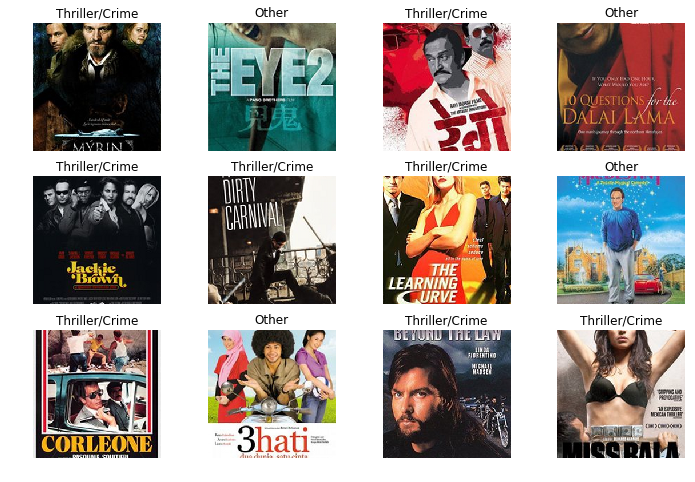

In [28]:
show_batch_bi('valid_bi.rec')

In [97]:
def _get_batch(batch, ctx):
    """Return features and labels on ctx."""
    features, labels = batch
    if labels.dtype != features.dtype:
        labels = labels.astype(features.dtype)
    return (gutils.split_and_load(features, ctx),
            gutils.split_and_load(labels, ctx), features.shape[0])

def train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs):
    """Train and evaluate a model."""
    print('training on', ctx)
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, m, start = 0.0, 0.0, 0, 0, time.time()
        for i, batch in enumerate(train_iter):
            Xs, ys, batch_size = _get_batch(batch, ctx)
            ls = []
            with autograd.record():
                y_hats = [net(X) for X in Xs]
                ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
            train_l_sum += sum([l.sum().asscalar() for l in ls])
            n += sum([l.size for l in ls])
            train_acc_sum += sum([(y_hat.argmax(axis=1) == y).sum().asscalar()
                                 for y_hat, y in zip(y_hats, ys)])
            m += sum([y.size for y in ys])
        test_acc, test_loss = evaluate_accuracy(test_iter, net, ctx)
        print('epoch %d, train loss %.4f, test loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, test_loss, train_acc_sum / m, test_acc,
                 time.time() - start))
        
def evaluate_accuracy(data_iter, net, ctx=[mx.cpu()]):
    """Evaluate accuracy of a model on the given data set."""
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    loss_sum, acc_sum, n, m = 0.0, 0.0, 0, 0
    loss = gloss.SoftmaxCrossEntropyLoss()
    for batch in data_iter:
        Xs, ys, batch_size = _get_batch(batch, ctx)
        y_hats = [net(X) for X in Xs]
        ys = [y.astype('float32') for y in ys]
        ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
        loss_sum += sum([l.sum().asscalar() for l in ls])
        n += sum([l.size for l in ls])
        acc_sum += sum([(y_hat.argmax(axis=1) == y).sum().asscalar() for y_hat, y in zip(y_hats, ys)])
        m += sum([y.size for y in ys])        
        
    return acc_sum / m, loss_sum / n

def get_model(what):
    if what == 'resnet34':
        pretrained_net = model_zoo.vision.resnet34_v2(pretrained=True)
        finetune_net = model_zoo.vision.resnet34_v2(classes=2)
    
    finetune_net.features = pretrained_net.features
    finetune_net.output.initialize(init.Xavier())
    return finetune_net

def train_fine_tuning(net, learning_rate, freeze=True, batch_size=64, num_epochs=5):
    
    train_iter = mx.gluon.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    test_iter = mx.gluon.data.DataLoader(validation_dataset, batch_size=batch_size)

    ctx = mx.gpu()
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    loss = gloss.SoftmaxCrossEntropyLoss()
    
    if freeze:
        params = net.output.collect_params()
    else:
        net.output.collect_params().setattr('lr_mult', 100)
        params = net.collect_params()
        learning_rate /= 100
    
    schedule = lr_scheduler.FactorScheduler(step=7, factor=0.7)
    trainer = gluon.Trainer(params, 'adam', {'learning_rate': learning_rate, 'lr_scheduler': schedule}) #, 'wd': 0.001
    train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs)

In [98]:
model = get_model('resnet34')

In [71]:
train_fine_tuning(model, 0.001, num_epochs=5)

training on gpu(0)
epoch 1, train loss 0.9087, test loss 0.8859, train acc 0.516, test acc 0.541, time 25.3 sec
epoch 2, train loss 0.8019, test loss 0.8325, train acc 0.555, test acc 0.564, time 25.4 sec
epoch 3, train loss 0.7287, test loss 0.7947, train acc 0.601, test acc 0.582, time 25.2 sec
epoch 4, train loss 0.7047, test loss 0.7952, train acc 0.604, test acc 0.600, time 25.1 sec
epoch 5, train loss 0.6892, test loss 0.7521, train acc 0.613, test acc 0.602, time 25.3 sec


In [99]:
train_fine_tuning(model, 0.001, freeze=False, num_epochs=10)

training on gpu(0)
epoch 1, train loss 0.7944, test loss 0.8632, train acc 0.543, test acc 0.523, time 25.6 sec
epoch 2, train loss 0.7155, test loss 0.8212, train acc 0.598, test acc 0.536, time 25.5 sec
epoch 3, train loss 0.7049, test loss 0.8172, train acc 0.619, test acc 0.532, time 25.5 sec
epoch 4, train loss 0.7170, test loss 0.8195, train acc 0.604, test acc 0.532, time 25.5 sec
epoch 5, train loss 0.6846, test loss 0.8170, train acc 0.619, test acc 0.527, time 25.7 sec
epoch 6, train loss 0.6918, test loss 0.8186, train acc 0.630, test acc 0.548, time 25.5 sec
epoch 7, train loss 0.7007, test loss 0.8116, train acc 0.621, test acc 0.525, time 25.5 sec
epoch 8, train loss 0.6949, test loss 0.8207, train acc 0.609, test acc 0.530, time 25.6 sec
epoch 9, train loss 0.7030, test loss 0.8190, train acc 0.618, test acc 0.525, time 25.5 sec
epoch 10, train loss 0.6913, test loss 0.8213, train acc 0.631, test acc 0.518, time 25.6 sec


In [2]:
from movies import *

In [3]:
model = build_graph('resnet50')

In [4]:
model = train_fine_tuning(model, FOLDER, 0.001)

training on gpu(0)
epoch 1, train loss 0.7027, test loss 0.7171, train acc 0.565, test acc 0.570, time 64.1 sec
epoch 2, train loss 0.6449, test loss 0.6390, train acc 0.626, test acc 0.661, time 40.6 sec
epoch 3, train loss 0.6279, test loss 0.6932, train acc 0.648, test acc 0.605, time 40.3 sec
epoch 4, train loss 0.6427, test loss 0.6354, train acc 0.636, test acc 0.666, time 40.3 sec
epoch 5, train loss 0.6135, test loss 0.6353, train acc 0.668, test acc 0.657, time 40.5 sec


In [6]:
model.export('resnet50')

In [18]:
sym, arg, aux = mx.model.load_checkpoint("resnet50", 0)

In [32]:
model = mx.mod.Module(symbol=sym)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/base_module.py:55: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)


In [33]:
model.set_params(arg, aux)

AssertionError: call bind before initializing the parameters

# START TEST

In [46]:
%%time
import boto3
import re
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()

s3_train = 's3://movies-posters-binary/train/'
s3_validation = 's3://movies-posters-binary/validation/'
bucket='s3://movies-posters-binary'

training_image = get_image_uri(boto3.Session().region_name, 'image-classification')

CPU times: user 71.6 ms, sys: 5.78 ms, total: 77.3 ms
Wall time: 376 ms


In [51]:
# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
# For this training, we will use 18 layers
num_layers = "18" 
# we need to specify the input image shape for the training data
image_shape = "3,128,128"
# we also need to specify the number of training samples in the training set
# for caltech it is 15420
num_training_samples = "1758"
# specify the number of output classes
num_classes = "2"
# batch size for training
mini_batch_size =  "64"
# number of epochs
epochs = "3"
# learning rate
learning_rate = "0.01"

In [63]:
%%time
import time
import boto3
from time import gmtime, strftime


s3 = boto3.client('s3')
# create unique job name 
job_name_prefix = 'DEMO-imageclassification'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://movies-posters-binary/output/'
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": '3,128,128',
        "num_layers": '34',
        "num_training_samples": '1758',
        "num_classes": '2',
        "mini_batch_size": '128',
        "epochs": '5',
        "learning_rate": '0.001',
        "use_pretrained_model": '0',
        "augmentation_type": 'crop_color_transform'
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_train,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_validation,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: DEMO-imageclassification-2019-02-19-18-00-24

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://movies-posters-binary/train/', 'S3DataDistributionType': 'FullyReplicated'}
CPU times: user 6.1 ms, sys: 0 ns, total: 6.1 ms
Wall time: 5.77 ms


In [ ]:
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

Training job current status: InProgress


In [65]:
training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info['TrainingJobStatus']
print("Training job ended with status: " + status)

Training job ended with status: Completed


In [67]:
job_name = 'DEMO-imageclassification-2019-02-19-17-50-13'

In [68]:
%%time
import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name='sagemaker') 

model_name="DEMO-full-image-classification-model"
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

hosting_image = get_image_uri(boto3.Session().region_name, 'image-classification')

primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

DEMO-full-image-classification-model
s3://movies-posters-binary/output/DEMO-imageclassification-2019-02-19-17-50-13/output/model.tar.gz
arn:aws:sagemaker:eu-west-1:257446244580:model/demo-full-image-classification-model
CPU times: user 179 ms, sys: 7.74 ms, total: 187 ms
Wall time: 484 ms


In [69]:
from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: DEMO-imageclassification-epc--2019-02-19-18-25-13
Endpoint configuration arn:  arn:aws:sagemaker:eu-west-1:257446244580:endpoint-config/demo-imageclassification-epc--2019-02-19-18-25-13


In [70]:
%%time
import time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: DEMO-imageclassification-ep--2019-02-19-18-25-57
EndpointArn = arn:aws:sagemaker:eu-west-1:257446244580:endpoint/demo-imageclassification-ep--2019-02-19-18-25-57
CPU times: user 15.8 ms, sys: 0 ns, total: 15.8 ms
Wall time: 224 ms


In [71]:
# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))


# wait until the status has changed
sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)


# print the status of the endpoint
endpoint_response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


In [72]:
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker')

In [73]:
import json
import numpy as np

with open('./340163.jpg', 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = ['Non Thriller', 'Thriller']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

Result: label - Thriller, probability - 0.9304366111755371


# END TEST

In [20]:
import os
import json

#os.mkdir('model')

#model.save_checkpoint('model/model', 0000)
#with open ( 'model/model-shapes.json', "w") as shapes:
#    json.dump([{"shape": model.data_shapes[0][1], "name": "data"}], shapes)

In [19]:
import tarfile

def flatten(tarinfo):
    tarinfo.name = os.path.basename(tarinfo.name)
    return tarinfo
    
tar = tarfile.open("model.tar.gz", "w:gz")
tar.add("model", filter=flatten)
tar.close()

In [21]:
import sagemaker

sagemaker_session = sagemaker.Session()
inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')

INFO:sagemaker:Created S3 bucket: sagemaker-eu-west-1-257446244580


In [24]:
from sagemaker import get_execution_role

role = get_execution_role()

In [25]:
from sagemaker.mxnet import MXNetModel

In [26]:
sagemaker_model = MXNetModel(model_data = 's3://' + sagemaker_session.default_bucket() + '/model/model.tar.gz',
                             role = role,
                             entry_point = 'movies.py')

In [27]:
predictor = sagemaker_model.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-mxnet-2019-02-19-15-44-25-074
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-2019-02-19-15-44-25-074


-----------------------------------------------------------------------------------------------------------------------------*

ValueError: Error hosting endpoint sagemaker-mxnet-2019-02-19-15-44-25-074: Failed Reason:  The primary container for production variant AllTraffic did not pass the ping health check. Please check CloudWatch logs for this endpoint.

In [2]:
import mxnet as mx
import sagemaker
from sagemaker.mxnet import MXNet as MXNetEstimator

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

In [4]:
data_location = 's3://movies-posters-binary'
output_path = 's3://sagemaker-movies-posters/artifacts'
hyperparameters = {'batch_size': 64, 'epochs': 5, 'learning_rate': 0.001}

In [5]:
estimator = MXNetEstimator(entry_point='movies-train.py', 
            role=sagemaker.get_execution_role(), 
            train_instance_count=1, 
            framework_version=1.3,
            train_instance_type='ml.p2.xlarge',
            output_path=output_path,
            hyperparameters = hyperparameters)

In [6]:
estimator.fit(data_location)

INFO:sagemaker:Created S3 bucket: sagemaker-eu-west-1-257446244580
INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-2019-02-17-17-12-11-603


2019-02-17 17:12:12 Starting - Starting the training job...
2019-02-17 17:12:14 Starting - Launching requested ML instances......
2019-02-17 17:13:14 Starting - Preparing the instances for training......
2019-02-17 17:14:38 Downloading - Downloading input data...
2019-02-17 17:14:58 Training - Downloading the training image..
2019-02-17 17:15:19,063 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2019-02-17 17:15:19,105 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_INPUT_DIR': '/opt/ml/input', 'SM_USER_ENTRY_POINT': 'movies-train.py', 'SM_TRAINING_ENV': '{"additional_framework_parameters":{},"channel_input_dirs":{"training":"/opt/ml/input/data/training"},"current_host":"algo-1","framework_module":"sagemaker_mxnet_container.training:main","hosts":["algo-1"],"hyperparameters":{"batch_size":64,"epochs":5,"learning_rate":0.001},"input_config_dir":"/opt/ml/input/config","input_data_config":{"training":{"RecordWrapperType":"N

In [7]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-mxnet-2019-02-17-17-12-11-603


ClientError: An error occurred (ValidationException) when calling the CreateModel operation: Could not find model data at s3://sagemaker-movies-posters/artifacts/sagemaker-mxnet-2019-02-17-17-12-11-603/output/model.tar.gz.